# Analyse von Luftverschmutzungsdaten

## Daten
- Quelle: die [API](https://aqs.epa.gov/aqsweb/documents/data_api.html#lists) der EPA (US-Umweltbehörde)
- Luftverschmutzung Tagesdaten von Los Angeles von 2019 (Corona Jahre vernachlässigen)

In [69]:
'Import der Module'
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests as requests
import json
from time import sleep
import os
import seaborn as sns
from additional_functions import * 
import datetime as datetime
from atmos import calculate

'Load df'
df_pollutant=pd.read_csv("Pollution_Data/pollutant_df.csv",index_col=0)

'Define important Variables'

#the years before 2000 doesnt have much data
years=[2000,2001,2002,2003,2004,2005,2006,
       2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2022]
#IDs for location
id={"la_n":1103,"pico_rivera":1602,"compton":1302,"signal_hill":4004}

#API Sign-Up
email="felixsch00@outlook.de"
#response_signup= requests.get(f"https://aqs.epa.gov/data/api/signup?email={email}")
#API Key via E-Mail
api_key="goldfox88" 
#Check if API is available --> 200 is working
response_available=requests.get("https://aqs.epa.gov/data/api/metaData/isAvailable")
print(f"Status Code Available: {response_available.status_code}")

Status Code Available: 200


In [2]:
'Get  some information about the parameters which can be requestet'
#Definitions
response_definition=requests.get(f"https://aqs.epa.gov/data/api/metaData/fieldsByService?email={email}&key={api_key}&service=sampleData")
print(f"Status Code E-Mail and Key okay: {response_definition.status_code}")

#Check available parameter classes (groups of parameter) -> to a JSON File
resp_parameter_classes=requests.get(f"https://aqs.epa.gov/data/api/list/classes?email={email}&key={api_key}")
with open("API_Infos/Parameter_Classes.json","w") as file:
    json.dump(resp_parameter_classes.json(),file,indent=4)
#Parameters from AQI POLLUTANTS   
def get_parameter_from_class(class_code:str,email=email,api_key=api_key):
    """Get the code and definition of available AQ Measurements, stores them in a JSON-File in API_Data Folder

    Args:
        class_code (str): Class Code shown in the Parameters_Classes.json file
        email (_type_, optional): For API. Defaults to email.
        api_key (_type_, optional): For API. Defaults to api_key.
    """
    parameters_api={"email":email,"key":api_key,"pc":class_code}
    req_parameters=requests.get("https://aqs.epa.gov/data/api/list/parametersByClass?",params=parameters_api)
    with open(f"API_Infos/Parameter_{class_code}.json","w") as file:
        json.dump(req_parameters.json(),file,indent=4)
    print(f"{class_code} Parameters successfully print to json file")
    return 

#Basic Pollutants
get_parameter_from_class("AQI POLLUTANTS")
#Meteorological Parameters
get_parameter_from_class("MET")
#Volatile organic compounds
get_parameter_from_class("VOC")



Status Code E-Mail and Key okay: 422
AQI POLLUTANTS Parameters successfully print to json file
MET Parameters successfully print to json file
VOC Parameters successfully print to json file


## Daten 

### API
AQS-API der US (EPA)[https://aqs.epa.gov/aqsweb/documents/data_api.html]

### Welche zeitliche Intervalle soll ich in meiner Analyse beobachten ?
- es können Daten bis zu den Messintervallen abgerufen werden (SampleData) -> damit könnte ich eigenen Intervalle (z.B. 6h) durch Mittelwertbildung berechnen
- einfacher ist es einfach die **täglichen Daten** Maxima zu betrachten (für eine genauere Betrachtung können ja auch die Mittelwerte betrachtet werden) --> Daily Summary Data by Site

### Messstadionen
- wichtig ist die Auswahl einer zentral gelegenen Messstadionen. In einer [Kartenansicht](https://epa.maps.arcgis.com/apps/webappviewer/index.html?id=5f239fd3e72f424f98ef3d5def547eb5&extent=-146.2334,13.1913,-46.3896,56.5319) wurden dies ausgewählt.
    + Los Angeles-North Main Street (Short: LA_N): AQS Site ID 06-037-1103
Für die Datenanalyse wird Los Angeles einfach als ein Punkt betrachtet, d.h. lokale Unterschiede oder eine unterschiedliche Position der Messstadion der Schadstoffe und anderen Features vernachlässigt. 

![Die drei makierten Messstadionen wurden ausgesucht.](Stations_Map.png) 

### Parameter

In dem Codeblock oben wurden die allgemein verfügbaren Messsubstanzen in JSON Files geschrieben. 
Zu den spannenden Schadstoffen (inkl Code für API) zählt: 
- CO 42101
- SO2 42401
- NO2 42602
- O3 44201
- PM10 (Feinstaub) 81102 (0-10um gesamt)
- PM2.5 88101 
- (Total NMOC 43102 (alle VOC ohne CH4))

#### CO 42101
- verschiedene SampleDurations (1h und 8h) -> hier 1h verwenden
- Einheit: ppm
- Um fehlerhafte Messungen auszuschließen muss bei validity_indicator "Y" sein und observation_percentage > 40 % sein (eigene Festlegung)

#### NO2
- SampeDuration: "1 HOUR"
- Einheit: ppb

#### SO2
- Sample Duration: "5 MINUTE"
- Einheit: ppb

#### PM2.5
- SampleDuration: 24 Hour
- Max Hours ist immer 0 --> daher nur date and mean columns
- Einheit: microgram/m3
#### O3
- SampleDuration: "8-HR RUN AVG BEGIN HOUR"
- - Einheit: ppm

#### PM10
- SampleDuration: 24 HOUR bzw. teilweise alle 6 Tage
- bei dem gewählten Ort (Los Angeles North) oder Signal Hill  sind nur selten Messwerte vorhanden bzw. die Sample Duration passt schlecht zu den anderen Werten
- **dieser Schadstoff wird nicht berücksichtigt**

#### Umrechnung von ppb/ppm in Konzentration
- [Info dazu](https://www.unternehmensberatung-babel.de/berechnungen/umrechnung-ppm.php) wird für die AQI bestimmung benötigt
- $$ \beta_i = \frac{0.1 \cdot M \cdot p \cdot X_i \cdot 1000}{R \cdot T}
- M: Molmasse in g/mol
- p: Referenzdruck in mbar --> 1000
- X_i: Konzentration in ppm
- R: molare Gaskonstante: 8.314
- T: temperatur: 300 K
- beta_i: Konzentration in microgram/m3
### AirQualityIndex (AQI)

- siehe https://www.eea.europa.eu/themes/air/air-quality-index -> bei About the Eu Air Q Index in der Kartenlegende
- **wichtig: Werte müssen in microgram/m3 gegeben sein**
!(Eigenes_Projekt/Dokumentation/AQI_index_Bedeutung.png)
!(Eigenes_Projekt/Dokumentation/AQI_index_Tabelle.png)

In [3]:
'Get the pollution data'
parameter_pollutant={"CO":42101,"SO2": 42401,"NO2": 42602 ,"O3" :44201,"PM10" : 81102,"PM2.5":88101}

for year in years:
    for parameter in parameter_pollutant.values():
        get_epa_data(parameter,year,site=id["la_n"],folder="Pollution_Data/raw")
        #additional data for pm10 at another station
        get_epa_data(parameter_pollutant["PM10"],year,site=4004,folder="Pollution_Data/raw")

Already exists: Year: 2000, Parameter: 42101, Site: 1103


TypeError: string indices must be integers

In [20]:
"Concat  json Pollution files for 88101 PM2.5 to one large file per different pollution. "
for parameter in [88101]:
    all_df=[]
    for year in years:
        path = get_epa_data(parameter,year,id["la_n"],only_get_path=True,folder="Pollution_Data/raw")
        with open(path) as file:
            data=json.load(file)
        
        df_single_year=pd.json_normalize(data["Data"])
        print(df_single_year.shape)
        df_single_year.drop(labels=["site_number","parameter_code","state_code","county_code","poc","latitude","longitude","datum","parameter","sample_duration_code",
                        "pollutant_standard","units_of_measure","event_type","method_code","method","local_site_name",
                        "site_address","state", "county","city","cbsa_code","cbsa","date_of_last_change",
                        "aqi"]
                ,axis=1,inplace=True)
        all_df.append(df_single_year)
    
    df_pm2_5=pd.DataFrame()
    df_pm2_5=pd.concat(all_df)

print(df_pm2_5.shape)
df_pm2_5=df_pm2_5[df_pm2_5["validity_indicator"]=="Y"]
df_pm2_5=df_pm2_5[df_pm2_5["observation_percent"]>50]
print(df_pm2_5.shape)
df_pm2_5["date"] = pd.to_datetime(df_pm2_5["date_local"],format="%Y-%m-%d")
#print(df_pm2_5.describe())
df_pm2_5.drop(labels=["first_max_value","first_max_hour","sample_duration","date_local","observation_percent","validity_indicator","observation_count"],inplace=True,axis=1)
df_pm2_5.columns = ["mean_pm2_5","date"]
df_pm2_5=df_pm2_5.groupby(["date"]).mean()
df_pm2_5.info()
df_pm2_5.head(10)
df_pm2_5.info()
df_pm2_5.head(5)


(2004, 32)
(1950, 32)
(1980, 32)
(1980, 32)
(2202, 32)
(2418, 32)
(2262, 32)
(2214, 32)
(2238, 32)
(5045, 32)
(2328, 32)
(2286, 32)
(2376, 32)
(2412, 32)
(828, 32)
(2382, 32)
(2466, 32)
(2514, 32)
(2436, 32)
(2508, 32)
(1242, 32)
(48071, 8)
(48068, 8)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6742 entries, 2000-01-01 to 2022-06-30
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   mean_pm2_5  6742 non-null   float64
dtypes: float64(1)
memory usage: 105.3 KB
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6742 entries, 2000-01-01 to 2022-06-30
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   mean_pm2_5  6742 non-null   float64
dtypes: float64(1)
memory usage: 105.3 KB


,mean_pm2_5
date,
2000-01-01,29.8
2000-01-04,17.5
2000-01-05,30.2
2000-01-06,24.3
2000-01-07,32.0


In [21]:
"Concat json Pollution files to one large file per different pollution."
"The Result will be stored as df in the all_pollutants list (except pm2.5 which is processed above seperatly)"

all_pollutants=[]
for key,parameter in {"co":42101,"so2": 42401,"no2": 42602 ,"o3" :44201}.items():
    all_years=[]
    print(key)
    print(parameter)
    for year in years:
        path=get_epa_data(parameter,year,id["la_n"],only_get_path=True,folder="Pollution_Data/raw")
        with open(path) as file:
            data=json.load(file)
        
        df_single_year=pd.json_normalize(data["Data"])
        print(df_single_year.shape)
        df_single_year.drop(labels=["site_number","parameter_code","state_code","county_code","poc","latitude","longitude","datum","parameter","sample_duration_code",
                        "pollutant_standard","units_of_measure","event_type","method_code","method","local_site_name",
                        "site_address","state", "county","city","cbsa_code","cbsa","date_of_last_change",
                        "aqi"]
                ,axis=1,inplace=True)
        all_years.append(df_single_year)
    
    
    df_single_pollutant=pd.DataFrame()
    df_single_pollutant=pd.concat(all_years)

    print(df_single_pollutant.shape)
    df_single_pollutant=df_single_pollutant[df_single_pollutant["validity_indicator"]=="Y"]
    df_single_pollutant=df_single_pollutant[df_single_pollutant["observation_percent"]>50]
    print(df_single_pollutant.shape)
    df_single_pollutant["date"] = pd.to_datetime(df_single_pollutant["date_local"],format="%Y-%m-%d")
    #print(df_single_pollutant.describe())
    df_single_pollutant.drop(labels=["sample_duration","date_local","observation_percent","validity_indicator","observation_count"],inplace=True,axis=1)
    print(df_single_pollutant.columns)
    df_single_pollutant.columns = [f"mean_{key}",f"max_value_{key}",f"max_hour_{key}","date"]
    df_single_pollutant=df_single_pollutant.groupby(["date"]).agg({f"mean_{key}":"mean",f"max_value_{key}":"max",f"max_hour_{key}":"mean"})
    df_single_pollutant[f"max_hour_{key}"]=np.round(df_single_pollutant[f"max_hour_{key}"])
    df_single_pollutant[f"max_hour_{key}"]=df_single_pollutant[f"max_hour_{key}"].astype("int8")
    df_single_pollutant.info()
    df_single_pollutant.head(10)
    df_single_pollutant.info()
    df_single_pollutant.head(10)
    all_pollutants.append(df_single_pollutant)


co
42101
(732, 32)
(730, 32)
(721, 32)
(730, 32)
(692, 32)
(730, 32)
(724, 32)
(718, 32)
(732, 32)
(712, 32)
(728, 32)
(897, 32)
(1067, 32)
(1447, 32)
(1453, 32)
(1096, 32)
(1365, 32)
(1381, 32)
(1247, 32)
(1014, 32)
(1084, 32)
(20000, 8)
(19763, 8)
Index(['arithmetic_mean', 'first_max_value', 'first_max_hour', 'date'], dtype='object')
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7503 entries, 2000-01-01 to 2022-09-30
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mean_co       7503 non-null   float64
 1   max_value_co  7503 non-null   float64
 2   max_hour_co   7503 non-null   int8   
dtypes: float64(2), int8(1)
memory usage: 183.2 KB
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7503 entries, 2000-01-01 to 2022-09-30
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mean_co       7503 non-null   float64
 1   max_value_co  

In [22]:
'Fügt alle Schadstoff Messwerte zusammen'
df_pollutant=pd.concat([*all_pollutants,df_pm2_5],axis=1)
df_pollutant[["mean_co","max_value_co"]]= change_pollution_unit(df_pollutant[["mean_co","max_value_co"]],"ppm","co")
df_pollutant[["mean_so2","max_value_so2"]]= change_pollution_unit(df_pollutant[["mean_so2","max_value_so2"]],"ppb","so2")
df_pollutant[["mean_no2","max_value_no2"]]= change_pollution_unit(df_pollutant[["mean_no2","max_value_no2"]],"ppb","no2")
df_pollutant[["mean_o3","max_value_o3"]]= change_pollution_unit(df_pollutant[["mean_o3","max_value_o3"]],"ppm","o3")
df_pollutant = df_pollutant.round(1)
df_pollutant.info()
#check number of rows if dropna
df_pollutant.dropna(axis=0).shape

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7571 entries, 2000-01-01 to 2022-09-30
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   mean_co        7503 non-null   float64
 1   max_value_co   7503 non-null   float64
 2   max_hour_co    7503 non-null   float64
 3   mean_so2       7054 non-null   float64
 4   max_value_so2  7054 non-null   float64
 5   max_hour_so2   7054 non-null   float64
 6   mean_no2       7075 non-null   float64
 7   max_value_no2  7075 non-null   float64
 8   max_hour_no2   7075 non-null   float64
 9   mean_o3        7344 non-null   float64
 10  max_value_o3   7344 non-null   float64
 11  max_hour_o3    7344 non-null   float64
 12  mean_pm2_5     6742 non-null   float64
dtypes: float64(13)
memory usage: 828.1 KB


(5834, 13)

In [23]:
"add AQI for each Pollutant based on max_value"

aqi_string=pd.CategoricalDtype(["Good","Fair","Moderate","Poor","Very Poor","Extremely Poor"],ordered=True)
df_pollutant.loc[df_pollutant["mean_pm2_5"]>=75,"aqi_pm2_5"] = "Extremely Poor"
df_pollutant.loc[df_pollutant["mean_pm2_5"]<75,"aqi_pm2_5"] = "Very Poor"
df_pollutant.loc[df_pollutant["mean_pm2_5"]<50,"aqi_pm2_5"] = "Poor"
df_pollutant.loc[df_pollutant["mean_pm2_5"]<25,"aqi_pm2_5"] = "Moderate"
df_pollutant.loc[df_pollutant["mean_pm2_5"]<20,"aqi_pm2_5"] = "Fair"
df_pollutant.loc[df_pollutant["mean_pm2_5"]<10,"aqi_pm2_5"] = "Good"
df_pollutant["aqi_pm2_5"] = df_pollutant["aqi_pm2_5"].astype(aqi_string)

df_pollutant.loc[df_pollutant["max_value_so2"]>=750,"aqi_so2"] = "Extremely Poor"
df_pollutant.loc[df_pollutant["max_value_so2"]<750,"aqi_so2"] = "Very Poor"
df_pollutant.loc[df_pollutant["max_value_so2"]<500,"aqi_so2"] = "Poor"
df_pollutant.loc[df_pollutant["max_value_so2"]<350,"aqi_so2"] = "Moderate"
df_pollutant.loc[df_pollutant["max_value_so2"]<200,"aqi_so2"] = "Fair"
df_pollutant.loc[df_pollutant["max_value_so2"]<100,"aqi_so2"] = "Good"
df_pollutant["aqi_so2"] = df_pollutant["aqi_so2"].astype(aqi_string)

df_pollutant.loc[df_pollutant["max_value_no2"]>=340,"aqi_no2"] = "Extremely Poor"
df_pollutant.loc[df_pollutant["max_value_no2"]<340,"aqi_no2"] = "Very Poor"
df_pollutant.loc[df_pollutant["max_value_no2"]<230,"aqi_no2"] = "Poor"
df_pollutant.loc[df_pollutant["max_value_no2"]<120,"aqi_no2"] = "Moderate"
df_pollutant.loc[df_pollutant["max_value_no2"]<90,"aqi_no2"] = "Fair"
df_pollutant.loc[df_pollutant["max_value_no2"]<40,"aqi_no2"] = "Good"
df_pollutant["aqi_no2"] = df_pollutant["aqi_no2"].astype(aqi_string)

df_pollutant.loc[df_pollutant["max_value_o3"]>=380,"aqi_o3"] = "Extremely Poor"
df_pollutant.loc[df_pollutant["max_value_o3"]<380,"aqi_o3"] = "Very Poor"
df_pollutant.loc[df_pollutant["max_value_o3"]<240,"aqi_o3"] = "Poor"
df_pollutant.loc[df_pollutant["max_value_o3"]<130,"aqi_o3"] = "Moderate"
df_pollutant.loc[df_pollutant["max_value_o3"]<100,"aqi_o3"] = "Fair"
df_pollutant.loc[df_pollutant["max_value_o3"]<50,"aqi_o3"] = "Good"
df_pollutant["aqi_o3"] = df_pollutant["aqi_o3"].astype(aqi_string)

In [24]:
"find the max aqi -> gets a new column"
aqi_skala={"Good":0,"Fair":1,"Moderate":2,"Poor":3,"Very Poor":4,"Extremely Poor":5}
pollutant_aqi=df_pollutant[["aqi_no2","aqi_o3","aqi_so2","aqi_pm2_5"]]
for column in pollutant_aqi.columns:
    pollutant_aqi[column] = pollutant_aqi[column].cat.rename_categories(aqi_skala)

pollutant_aqi = pollutant_aqi.astype(np.float64)

df_pollutant["aqi_idxmax"]=pollutant_aqi.idxmax(axis=1)
df_pollutant["aqi_max"] = pollutant_aqi.max(axis=1).astype(pd.CategoricalDtype([1,2,3,4,5],ordered=True))
df_pollutant["aqi_max"] = df_pollutant["aqi_max"].cat.rename_categories({value:key for key,value in aqi_skala.items()})
df_pollutant["aqi_max"]

/tmp/ipykernel_7449/2696942306.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pollutant_aqi[column] = pollutant_aqi[column].cat.rename_categories(aqi_skala)
/tmp/ipykernel_7449/2696942306.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pollutant_aqi[column] = pollutant_aqi[column].cat.rename_categories(aqi_skala)
/tmp/ipykernel_7449/2696942306.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

Se

date
2000-01-01        Poor
2000-01-02        Fair
2000-01-03        Poor
2000-01-04    Moderate
2000-01-05        Poor
                ...   
2022-09-26        Poor
2022-09-27        Poor
2022-09-28        Poor
2022-09-29    Moderate
2022-09-30    Moderate
Name: aqi_max, Length: 7571, dtype: category
Categories (5, object): ['Fair' < 'Moderate' < 'Poor' < 'Very Poor' < 'Extremely Poor']

In [25]:
df_pollutant.to_hdf("Pollution_Data/pollutant_data.h5","data",format="table")

## Daten zur Vorhersage der Schadstoffe

### Meterologische Daten aus der AQS API der EPA


Die folgenden Parameter werden abgerufen: 
- Wind-Geschwindigkeit (in Knoten)
- Wind-Richtung (beides vektoriell, auch als Resultant bezeichnet) (in Grad Kompass)
- Temperatur (raw: Fahrenheit -> Celsius) 
- Tempertur max 
- Feuchtigkeit (in %) + max
- Solar radiation (langleys/minute)
- UV radiation  (")
- barometric pressure (in mbar)

Gut wären außerdem noch (an Stadion nicht verfügbar):
- min T 62105 -> NOAA 
- differenz min max T 62106 oder selbst berechnen -> NOAA
- visibility 63101
- rain 65101 -> NOAA
- Cloud cover 66101

vieleicht hier zu finden (https://www.ncdc.noaa.gov/cdo-web/webservices)

### Kalenderdaten
- Wochentag
- Monat

In [2]:
meterologic_parameter={"wind_speed":61103 , "wind_direction":61104, "temp":62101,
                       "humidity":62201,"radiation":63301, "uv_radiation": 63302,
                       "pressure":64101}

site_la_north=1103

for year in years:
    for parameter in meterologic_parameter.values(): 
        get_epa_data(parameter,year,site_la_north,folder="Predictor_Data/raw_aqs")

Already exists: Year: 2000, Parameter: 61103, Site: 1103
Already exists: Year: 2000, Parameter: 61104, Site: 1103
Already exists: Year: 2000, Parameter: 62101, Site: 1103
Already exists: Year: 2000, Parameter: 62201, Site: 1103
Already exists: Year: 2000, Parameter: 63301, Site: 1103


TypeError: string indices must be integers

In [42]:
'Concat the meterologic_parameter'
all_meterologic_parameter=[]
for key,parameter in meterologic_parameter.items():
    all_years=[]
    print(key)
    print(parameter)
    for year in years:
        print(year)
        path=get_epa_data(parameter,year,id["la_n"],only_get_path=True,folder="Predictor_Data/raw_aqs")
        try:
            with open(path) as file:
                data=json.load(file)
            
            df_single_year=pd.json_normalize(data["Data"])
            print(df_single_year.shape)
            df_single_year.drop(labels=["site_number","parameter_code","state_code","county_code","poc","latitude","longitude","datum","parameter","sample_duration_code",
                            "pollutant_standard","units_of_measure","event_type","method_code","method","local_site_name",
                            "site_address","state", "county","city","cbsa_code","cbsa","date_of_last_change",
                            "aqi"]
                    ,axis=1,inplace=True)
            all_years.append(df_single_year)
        except:
            print("File not available")
        
    single_meterologic_parameter=pd.DataFrame()
    single_meterologic_parameter=pd.concat(all_years)

    print(single_meterologic_parameter.shape)
    single_meterologic_parameter=single_meterologic_parameter[single_meterologic_parameter["validity_indicator"]=="Y"]
    single_meterologic_parameter=single_meterologic_parameter[single_meterologic_parameter["observation_percent"]>40]
    print(single_meterologic_parameter.shape)
    single_meterologic_parameter["date"] = pd.to_datetime(single_meterologic_parameter["date_local"],format="%Y-%m-%d")
    #print(single_meterologic_parameter.describe())
    single_meterologic_parameter.drop(labels=["sample_duration","date_local","observation_percent","validity_indicator","observation_count"],inplace=True,axis=1)
    print(single_meterologic_parameter.columns)
    single_meterologic_parameter.columns = [f"mean_{key}",f"max_value_{key}",f"max_hour_{key}","date"]
    single_meterologic_parameter=single_meterologic_parameter.groupby(["date"]).agg({f"mean_{key}":"mean",f"max_value_{key}":"max",f"max_hour_{key}":"mean"})
    single_meterologic_parameter[f"max_hour_{key}"]=np.round(single_meterologic_parameter[f"max_hour_{key}"])
    single_meterologic_parameter[f"max_hour_{key}"]=single_meterologic_parameter[f"max_hour_{key}"].astype("int8")
    single_meterologic_parameter.info()
    single_meterologic_parameter.head(10)
    single_meterologic_parameter.info()
    single_meterologic_parameter.head(10)
    all_meterologic_parameter.append(single_meterologic_parameter)

all_meterologic_parameter = pd.concat(all_meterologic_parameter,axis=1)
#change Unit from fahrenheit to celsius 
all_meterologic_parameter[["max_value_temp","mean_temp"]] = (all_meterologic_parameter[["max_value_temp","mean_temp"]] -32 ) * 5/9
all_meterologic_parameter.info()
all_meterologic_parameter.to_csv("Predictor_Data/meterologic_parameter.csv")


wind_speed
61103
2000
(282, 32)
2001
(250, 32)
2002
(365, 32)
2003
(175, 32)
2004
(331, 32)
2005
(353, 32)
2006
(334, 32)
2007
(363, 32)
2008
(329, 32)
2009
(90, 32)
2010
File not available
2011
File not available
2012
File not available
2013
File not available
2014
(365, 32)
2015
(87, 32)
2016
(275, 32)
2017
(365, 32)
2018
(365, 32)
2019
(365, 32)
2022
File not available
(4694, 8)
(4647, 8)
Index(['arithmetic_mean', 'first_max_value', 'first_max_hour', 'date'], dtype='object')
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4647 entries, 2000-01-01 to 2019-12-31
Data columns (total 3 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   mean_wind_speed       4647 non-null   float64
 1   max_value_wind_speed  4647 non-null   float64
 2   max_hour_wind_speed   4647 non-null   int8   
dtypes: float64(2), int8(1)
memory usage: 113.5 KB
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4647 entries, 2000-01-01 to 2019-1

In [43]:
def get_direction(degree):
    """ Gibt die Himmelsrichtung des Windes wieder, statt des Angabe in Grad."""
    if np.isnan(degree):
        return np.nan
    elif degree >=45 and degree <135:
        return "west"
    elif degree >=135 and degree <225:
        return "south"
    elif degree >=225 and degree <315:
        return "east"
    elif degree >=315 and degree <45:
        return "north"
    else:
        return np.nan

#umwandeln der windrichtung von grad in Himmelsrichtungen
all_meterologic_parameter["mean_wind_direction"]=(all_meterologic_parameter["mean_wind_direction"].map(get_direction)).astype(pd.CategoricalDtype(categories=["north","south","east","west"]))
all_meterologic_parameter["mean_wind_direction"].value_counts()

#convert to dummy variables
wind_dummi= pd.get_dummies(all_meterologic_parameter["mean_wind_direction"],prefix="wind")
all_meterologic_parameter = all_meterologic_parameter.join(wind_dummi)
all_meterologic_parameter.drop(["mean_wind_direction"],axis=1,inplace=True)

In [36]:
'test if parameter_test are available'
# all not available at La_N and other stations in La
parameter_test=[62105,62106,63101,65102,66101,61105,61106,61120,61202,62108,62604,63303,63304,63305,65101,65103]

for year in [2019]:
    for parameter in parameter_test:
        print(parameter)
        get_epa_data(parameter,year,1302,folder="Predictor_Data/raw_aqs")

62105
Request Empty
62106
Request Empty
63101
Request Empty
65102
Request Empty
66101
Request Empty
61105
Request Empty
61106
Request Empty
61120
Request Empty
61202
Request Empty
62108
Request Empty
62604
Request Empty
63303
Request Empty
63304
Request Empty
63305
Request Empty
65101
Request Empty
65103
Request Empty


### Daten zum Stromverbrauch 
Daten aus der API der EIA und beziehen sich auf das ganze County Los Angeles in einer täglichen Basis. Dabei sind leider nur die Daten ab Mitte 2015 verfügbar. 
- demand: in MWh
- net_generation: in MWh  

Die URL zum API Request wurde dabei in einem [Online-Tool](https://www.eia.gov/opendata/browser/) erstellt.

In [40]:
'Load the electricity data from EIA API'
'Note: The request string is constructed online via an interface'
eia_apikey="ji4rAKmmenbLRssSzeJ98DoW2Gf76lrXkmWHyK2e"
"api_key=ji4rAKmmenbLRssSzeJ98DoW2Gf76lrXkmWHyK2e&"
#reguest the net generation of electricity in the LA region
req_net_generation=requests.get("https://api.eia.gov/v2/electricity/rto/daily-region-data/data/?api_key=ji4rAKmmenbLRssSzeJ98DoW2Gf76lrXkmWHyK2e&frequency=daily&data[0]=value&facets[type][]=NG&facets[respondent][]=LDWP&facets[timezone][]=Pacific&start=2015-06-30&end=2022-12-01&sort[0][column]=period&sort[0][direction]=desc&offset=0&length=5000")
req_demand=requests.get("https://api.eia.gov/v2/electricity/rto/daily-region-data/data/?api_key=ji4rAKmmenbLRssSzeJ98DoW2Gf76lrXkmWHyK2e&frequency=daily&data[0]=value&facets[respondent][]=LDWP&facets[timezone][]=Pacific&facets[type][]=D&start=2015-06-30&end=2022-12-01&sort[0][column]=period&sort[0][direction]=desc&offset=0&length=5000")
with open("Predictor_Data/electricity_net_generation.json","w") as file:
                json.dump(req_net_generation.json(),file,indent=4)
with open("Predictor_Data/electricity_demand.json","w") as file:
                json.dump(req_demand.json(),file,indent=4)

/home/felix/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3369: UserWarning: Parsing '31/12/2021' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  exec(code_obj, self.user_global_ns, self.user_ns)


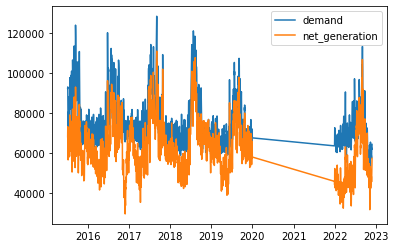

In [41]:
with open("Predictor_Data/electricity_demand.json") as file:
    electricity_demand=pd.json_normalize(json.load(file)["response"]["data"])
with open("Predictor_Data/electricity_net_generation.json") as file:
    electricity_net_generation=pd.json_normalize(json.load(file)["response"]["data"])

#change columnames and make date column
electricity_demand["demand_electricity"]=electricity_demand["value"]
electricity_net_generation["net_generation_electricity"]=electricity_net_generation["value"]
electricity_demand["date"]=pd.to_datetime(electricity_demand["period"],format="%Y-%m-%d")
electricity_net_generation["date"]=pd.to_datetime(electricity_net_generation["period"],format="%Y-%m-%d")

# delete other columns and set date as index
electricity_demand=electricity_demand[["date","demand_electricity"]].set_index("date")
electricity_net_generation=electricity_net_generation[["date","net_generation_electricity"]].set_index("date")
electricity=pd.concat([electricity_demand,electricity_net_generation],axis=1)

#delete year 2020,2021
electricity = electricity.drop(pd.date_range(start='01/01/2020', end='31/12/2021'),errors="ignore")
electricity.to_csv("Predictor_Data/electricity.csv")

plt.plot(electricity.index,electricity["demand_electricity"],label="demand")
plt.plot(electricity.index,electricity["net_generation_electricity"],label="net_generation")
plt.legend()

### Wetter Daten 
Um weitere Wetter Daten zu erhaten wird auf die Daten der [NOAA](https://www.ncei.noaa.gov/cdo-web/search?datasetid=GHCND) zurückgegriffen. Dabei werden die Daily Summary Daten online als .csv abgerufen (die API sieht ziemlich anstrengend aus :)
- rain in mm/m²
- t_max in °C
- t_min in °C
- t_minmax als berechnete Differenz zwischen den beiden Werten  
  
Die Daten sind hier ab von 2000 bis 2020 + 2022 abgerufen und die Stadion befindet sich auch in Downtown LA.

In [76]:
# load the csv File and process it
#data from 2010 till 2020
weather=pd.read_csv("Predictor_Data/full_weather_2000_2023_downtown.csv")
weather=weather[["DATE","PRCP","TAVG","TMAX","TMIN","AWND","WSF2"]]
weather=weather.set_index("DATE")
weather.index = pd.to_datetime(weather.index)
#conversion to degree celsius
weather[["TAVG","TMAX","TMIN"]]=(weather[["TAVG","TMAX","TMIN"]] -32)* (5/9)

#Rain as Boolean
def rain_bool(rain_value):
    if np.isnan(rain_value):
        return False
    elif rain_value>0:
        return True
    else: 
        return False

#have to be type int (if bool storage as h5 result in an error)
weather["PRCP"]= weather["PRCP"].map(rain_bool).astype(bool).astype(int)

#new columns
weather["t_minmax"]=weather["TMAX"]-weather["TMIN"]
weather.to_csv("Predictor_Data/weather.csv")
weather.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8408 entries, 2000-01-01 to 2023-01-07
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   PRCP      8408 non-null   int64  
 1   TAVG      2025 non-null   float64
 2   TMAX      8408 non-null   float64
 3   TMIN      8408 non-null   float64
 4   AWND      8358 non-null   float64
 5   WSF2      8364 non-null   float64
 6   t_minmax  8408 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 525.5 KB


In [6]:
'Kalenderdaten'
date_range = pd.date_range("01/01/2000",end="31/12/2022")
kalender=pd.DataFrame(index=date_range,data={"day_of_week":(date_range.day_of_week +1),
                                             "month":date_range.month,
                                             "quarter":date_range.quarter,
                                             "year":date_range.year})

def check_business_day(day_of_week):
    if day_of_week>5:
        return False
    elif day_of_week<=5:
        return True

kalender["business_day"]=kalender["day_of_week"].map(check_business_day).astype(int)

kalender.info()
kalender.head(5)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8401 entries, 2000-01-01 to 2022-12-31
Freq: D
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   day_of_week   8401 non-null   int64
 1   month         8401 non-null   int64
 2   quarter       8401 non-null   int64
 3   year          8401 non-null   int64
 4   business_day  8401 non-null   int64
dtypes: int64(5)
memory usage: 393.8 KB


/tmp/ipykernel_2832/2100096060.py:2: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  date_range = pd.date_range("01/01/2000",end="31/12/2022")


,day_of_week,month,quarter,year,business_day
2000-01-01,6,1,1,2000,0
2000-01-02,7,1,1,2000,0
2000-01-03,1,1,1,2000,1
2000-01-04,2,1,1,2000,1
2000-01-05,3,1,1,2000,1


In [77]:
'Zusammenfügen aller Dataframes zur Vorhersage'
df_predictor=kalender.join(weather,how="left")
df_predictor=df_predictor.join(all_meterologic_parameter,how="left")
'Drop the covid-19 time'
df_predictor = df_predictor.drop(pd.date_range(start='01/01/2020', end='31/12/2021'),errors="ignore")


/tmp/ipykernel_2832/680382915.py:5: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df_predictor = df_predictor.drop(pd.date_range(start='01/01/2020', end='31/12/2021'),errors="ignore")


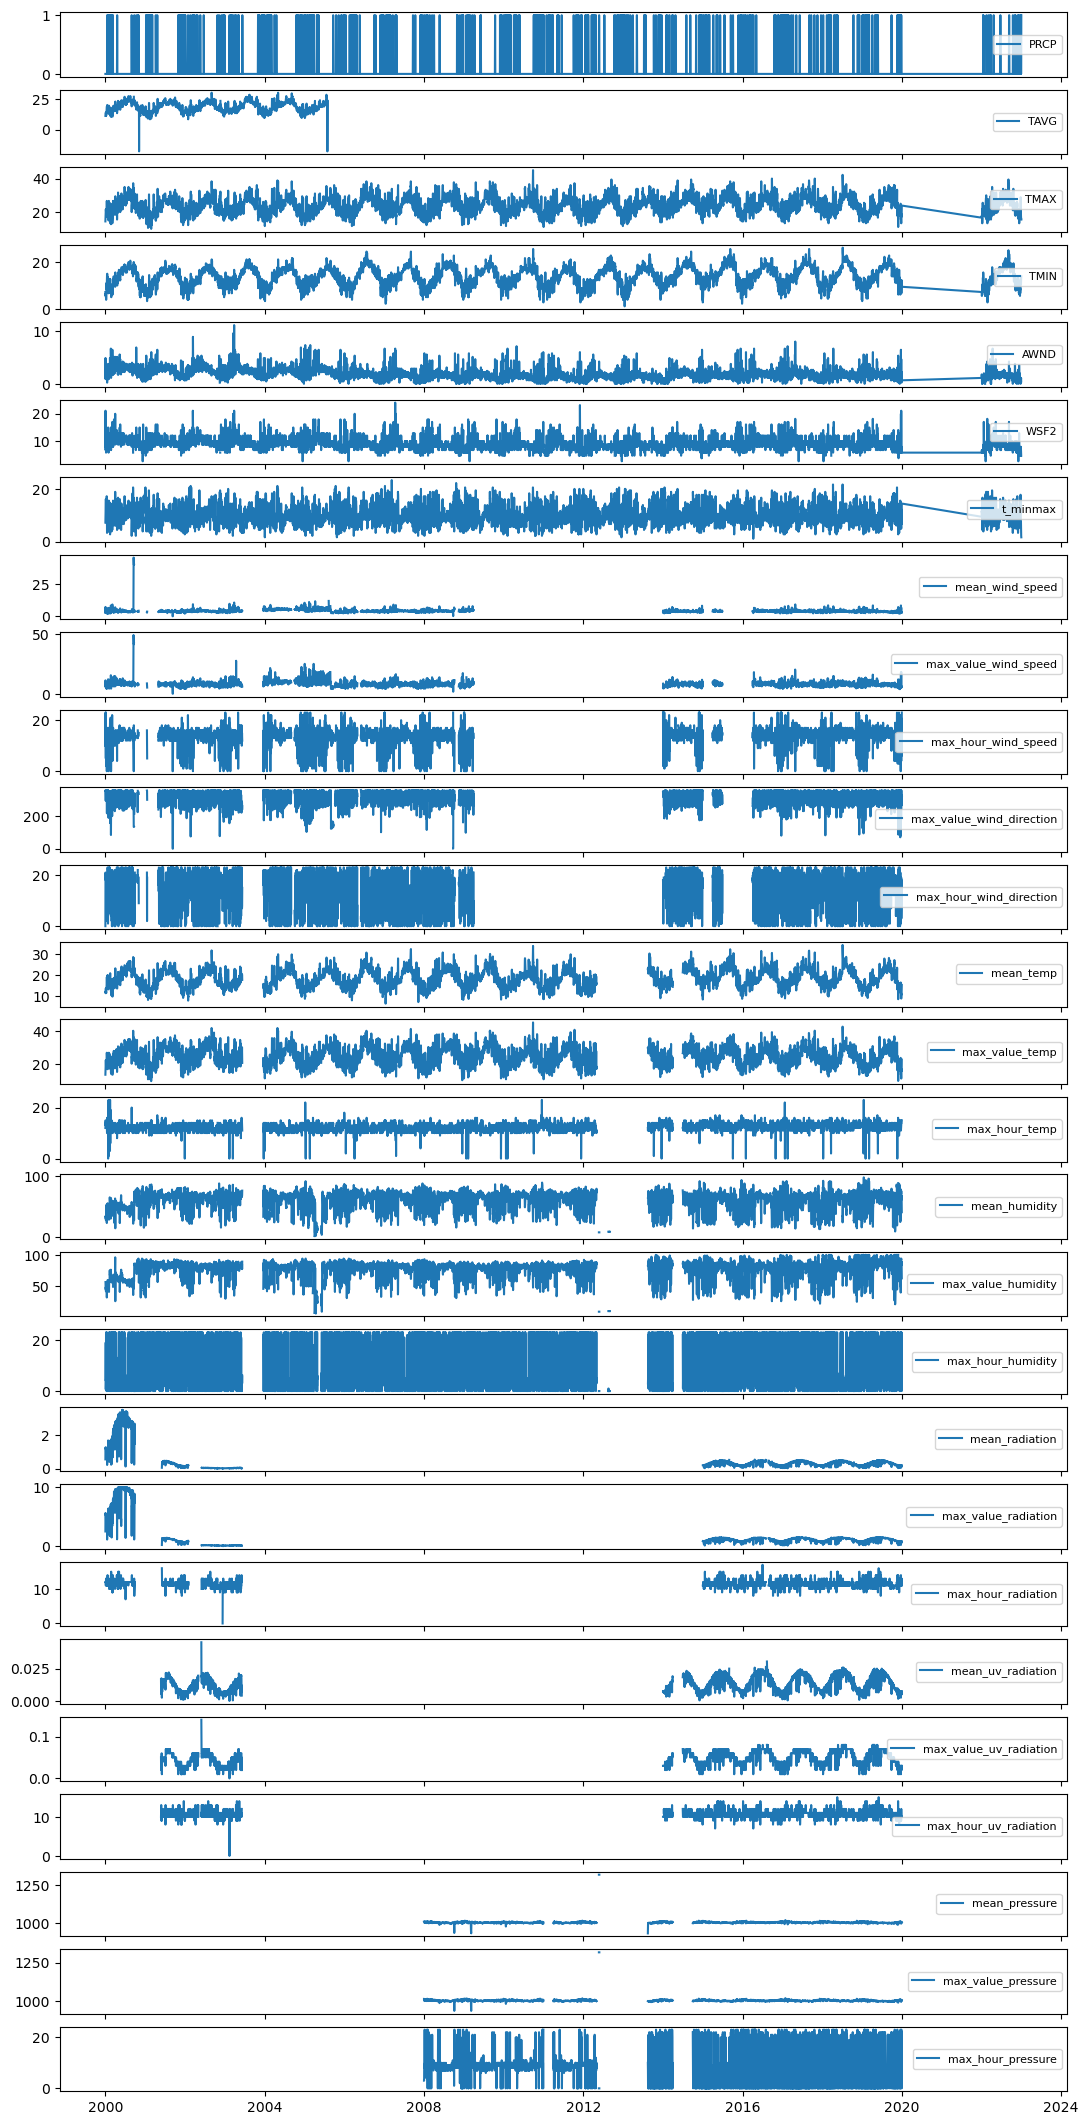

In [78]:
col_date_plot=df_predictor.columns[5:] #exclude kalender and wind direction dummies
fig, multiple_ax = plt.subplots(len(col_date_plot),1,figsize=(13,len(col_date_plot)),sharex = True)
for index,column in enumerate(col_date_plot):
    multiple_ax[index].plot(df_predictor[column],label=column)
    multiple_ax[index].legend(loc="right",fontsize=8)


Erklärung zu einigen Features: **PRCP** Niederschlag, **AWND** durchnittlicher Windgeschwindigkeit, **WSF2** schnellste Windgeschwindigkeit innerhalb von 2 Minuten
Nach der Betrachtung im zeitlichen Verlauf fällt auf das bei einigen Stadionen die Wert fast komplett bzw. bei großen zeitlichen Bereichen fehlen.
Da mit AWND und WSF2 der Wind schon gegeben ist, werden alle Spalten mit _wind_speed entfernt. 

In [81]:
'Save to h5 file'
df_predictor.drop(axis=1,labels=['mean_wind_speed',
       'max_value_wind_speed', 'max_hour_wind_speed',
       'max_value_wind_direction', 'max_hour_wind_direction',])
df_predictor.to_hdf("Predictor_Data/all.h5",key="data",format="table")